In [1]:
"""
Cifar-10 데이터셋을 이용한 분류기 모델 학습기
"""

'\nCifar-10 데이터셋을 이용한 분류기 모델 학습기\n'

https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [2]:
# 학습에 필요한 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# 이미지를 정규화 시키는 코드
# -0.5~0.5로 정규화하는 것이 낫다 > 0~1
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

# 데이터 셋을 불러오는 과정
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2) # cpu 사용개수

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


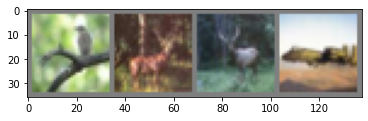

bird  deer  deer  plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (RGB 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# 손실함수와 옵티마이저 정의하기
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# 신경망 학습하기
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999: # 2000 mini-batches
            print(f'[{epoch + 1}, {i+1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print("Traning finish")

[1,  2000] loss: 2.192
[1,  4000] loss: 1.873
[1,  6000] loss: 1.670
[1,  8000] loss: 1.582
[1, 10000] loss: 1.507
[1, 12000] loss: 1.481
[2,  2000] loss: 1.393
[2,  4000] loss: 1.338
[2,  6000] loss: 1.330
[2,  8000] loss: 1.312
[2, 10000] loss: 1.294
[2, 12000] loss: 1.223
Traning finish


In [8]:
# pretrained-model 저장하기
# 추후에 해당 모델 불러올 수 있음
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

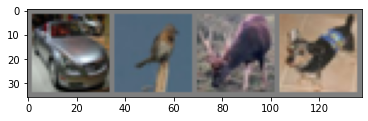

GroundTruth:  car   bird  deer  frog 


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
# 저장된 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))
# net.load_state_dict(torch.load(r'./cifar_net.pth')) # 경로 앞 r은 한국어 경로일때
# PATH = 경로

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  car   bird  car   bird 


In [13]:
# 전체 데이터셋에 대해서는 어떻게 동작하는지
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [14]:
# 정확도 개선 : layer 더 쌓기, 에폭 수 늘리기

In [17]:
# 각 클래스에 대한 정확도
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

IndexError: tuple index out of range